In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    

In [3]:
csv_file = "../data-generation/04-28-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [4]:
df_wo.columns

Index(['Structure Number', 'Age', 'ADT Type', 'ADTT Type', 'Superstructure',
       'Avg. Daily Precipitation', 'State Code', 'Average Daily Traffic',
       'Owner', 'Maintainer', 'Length Of Maximum Span', 'Structure Length',
       'Structure Type', 'Kind Of Material', 'Year', 'No Change Span',
       'No Change structure length', 'Average ADT', 'ADT Category',
       'ADTT Category', 'Length Of Maximum Span Flat', 'Material', 'Year Last',
       'Constant', 'Mean Age', 'Deterioration Score',
       'Baseline Difference Score', 'Scaled Baseline Difference Score'],
      dtype='object')

In [4]:
df_wo[df_wo['No Change structure length'] == True].shape

(292488, 28)

In [5]:
df_wo.shape

(435482, 28)

In [6]:
df_wo = df_wo[df_wo['No Change structure length'] == True]

In [7]:
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]

In [8]:
df_wo = df_wo[df_wo['Structure Length']>6]

In [9]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['structurelength'] = pd.qcut(df_wo['Structure Length'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength','structurelength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength",\
                                               "structurelength":"structurelength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

In [10]:
df_wo.shape

(291455, 31)

In [11]:
df_anova.head()

,score,adt,adtt,precp,region,precipitation,lengthofspan,material,structuretype,maintainer,spanlength,structurelength
5,0.634804,Very Light,Light,0.87,West,Very Low,16.2,7,2,1,Medium,Very High
1061,0.391678,Moderate,Light,0.84,West,Very Low,9.1,7,2,1,Medium,Medium
2005,-0.750304,Light,Light,0.71,West,Very Low,7.9,1,2,26,Medium,Very Low
2697,-0.940536,Light,Light,1.14,West,Very Low,7.3,7,2,26,Medium,Very Low
3012,0.155585,Light,Light,0.90,West,Very Low,9.8,3,2,26,Medium,Medium


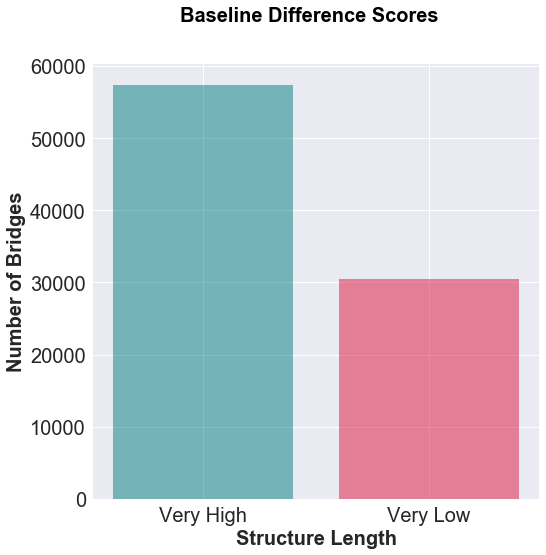

In [12]:
count_structurelen = df_anova.groupby('structurelength')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_structurelen[0], count_structurelen[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Structure Length", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

In [13]:
l = df_wo[df_wo['structurelength']== 'Very Low']
h = df_wo[df_wo['structurelength']== 'Very High']


l['Structure Length'].describe()

count    30371.000000
mean         7.434727
std          0.683810
min          6.100000
25%          7.000000
50%          7.300000
75%          7.900000
max          8.500000
Name: Structure Length, dtype: float64

In [14]:
h['Structure Length'].describe()

count    57040.000000
mean       150.924676
std        283.844802
min         61.100000
25%         72.800000
50%         90.200000
75%        133.800000
max      23382.400000
Name: Structure Length, dtype: float64

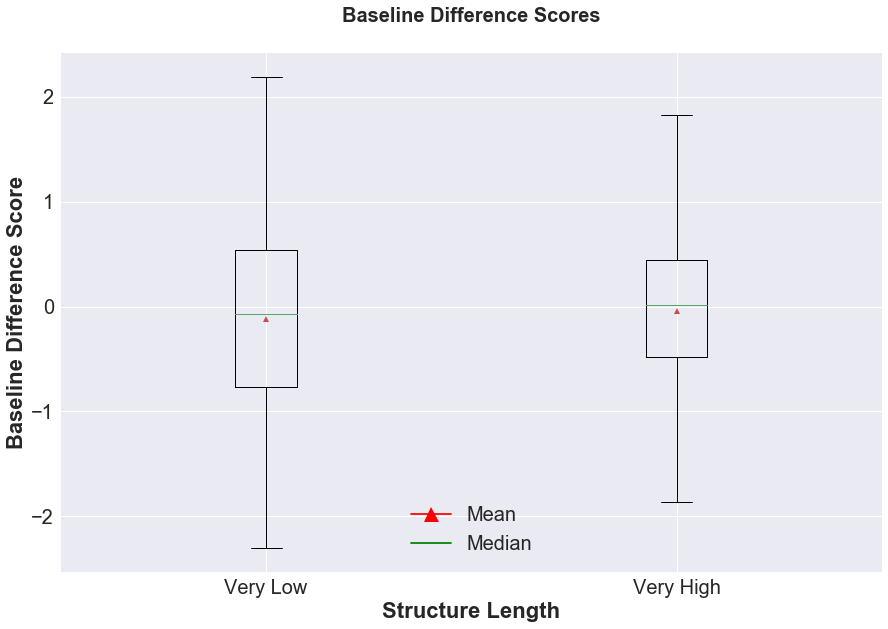

In [15]:
scores_low = df_anova[df_anova['structurelength'] == 'Very Low']['score']
scores_high = df_anova[df_anova['structurelength'] == 'Very High']['score']

scores_structurelen = [scores_low,scores_high]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')

# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_structurelen, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Structure Length", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

#### ANOVA - Small Sample

In [16]:
span = df_anova.groupby('structurelength').apply(lambda s: s.sample(100))['structurelength'].tolist()
score = df_anova.groupby('structurelength').apply(lambda s: s.sample(100))['score'].tolist()
df_span_sample_100 = pd.DataFrame({'structurelength':span, 'score':score})
df_span_100 = df_span_sample_100[df_span_sample_100['structurelength'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(structurelength)'
span_undersample = undersample(df_span_100, 'structurelength')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(structurelength),0.660159,1.0,0.992795,0.320276,0.004989,-0.000036
Residual,131.660077,198.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [19]:
samplesize = min(df_anova.groupby(['structurelength'])['structurelength'].count())
span = df_anova.groupby('structurelength').apply(lambda s: s.sample(samplesize))['structurelength'].tolist()
score = df_anova.groupby('structurelength').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_span_sample_45121 = pd.DataFrame({'structurelength':span, 'score':score})
df_span_45121 = df_span_sample_45121[df_span_sample_45121['structurelength'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(structurelength)'
span_undersample = undersample(df_span_45121, 'structurelength')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(structurelength),93.173070,1.0,135.599049,2.636006e-31,0.002223,0.002207
Residual,41812.739179,60852.0,NaN,NaN,NaN,NaN
